In [1]:
%matplotlib qt
import sys
import mne
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append(r"C:\Users\gautier\OneDrive - CentraleSupelec\3A - Master CNN\Supervised Project\pipeline project v0\scripts")
sys.path.append(r"C:\Users\gautier\OneDrive - CentraleSupelec\3A - Master CNN\Supervised Project\pipeline project v0\config")
import eeg_preprocessing as preprocessing
import vst_config as config


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Producing and exploring go_signal and start_prod epochs

## Check go_signal and start_prod events are well distributed

In [2]:
def check_go_signal_and_start_prod_events(block, block_number):
    # choose threshold in seconds to detect too big of a difference between go_signal and start_prod
    threshold = 5

    # Retrieve events
    start_prod_events_dict = {k:v for k,v in config.evts_id.items() if "start_prod" in k}
    start_prod_events, start_prod_events_dict_block = mne.events_from_annotations(block, event_id=start_prod_events_dict, verbose=False)
    go_signal_events_dict = {k:v for k,v in config.evts_id.items() if "go_signal" in k}
    go_signal_events, go_signal_events_dict_block = mne.events_from_annotations(block, event_id=go_signal_events_dict, verbose=False)

    #The way MNE works here is a bit odd: when cropping a raw, events onset times do not change, 
    # which results in a misalignment between the cropped raw and the events.
    # However, first_samp and last_samp change as expected: first_samp updates from 0 to the first time sample in the raw from which it was cropped
    start_prod_events[:,0] = start_prod_events[:,0] - block.first_samp
    go_signal_events[:,0] = go_signal_events[:,0] - block.first_samp

    if len(start_prod_events) != len(go_signal_events):
        print("[WARNING] Numbers of go_signal events and start_prod events do not match for block n°" + str(block_number))

    else:
        negative_diff_event_indices = []
        long_diff_event_indices = []
        for i in range(len(go_signal_events)):
            delta_between_go_and_start = block.times[start_prod_events[i][0]]-block.times[go_signal_events[i][0]]
            if delta_between_go_and_start < 0:
                print("Start_prod event before go_signal for event n°" + str(i))
                negative_diff_event_indices.append(i)
            if delta_between_go_and_start > threshold:
                print("Time difference of " + str(delta_between_go_and_start) + " greater than " + str(threshold) + "s for event n°" + str(i))
                long_diff_event_indices.append(i)
        print("negative diff events indices : " + str(negative_diff_event_indices))
        print("long diff events indices : " + str(long_diff_event_indices))    

Test with one subject

In [3]:
#Import one subject data
subject = 'VST_02_X'
preprocessed_raw = preprocessing.get_preprocessed_raw(subject, bad_channels_exclusion=True, ICA_exclusion=True)
raw_blocks = preprocessing.get_good_raw_blocks(preprocessed_raw)

C:\Users\gautier\OneDrive - CentraleSupelec\3A - Master CNN\Supervised Project\pipeline project v0\scripts\eeg_preprocessing.py:44: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn", verbose=False)


[DONE] Importing data
[DONE] Filtering and resampling
[DONE] Excluding bad channels
Reading C:\Users\gautier\Données EEG - Supervised Project/ica_solutions/VST_02_X-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (63 components)
    Zeroing out 2 ICA components
    Projecting back using 63 PCA components
[DONE] Performing ICA
[0, 1, 502, 1003, 1508, 1511, 2018, 2523, 3031, 3541, 4045]
-97.344
594.24
580.66
572.104
1.2159999999998945
527.8559999999998
530.0
553.3000000000002
511.25199999999995
522.1079999999993
[DONE] Extracting good blocks


In [6]:
time_production_blocks_indices = []
for i, block in enumerate(raw_blocks):
    print("\nChecking Block n°" + str(i))

    #Check whether there are start_prod or go_signal events
    go_signal_descriptions_block = [annotation['description'] for annotation in block.annotations if ('go_signal' in annotation['description'])]
    start_prod_descriptions_block = [annotation['description'] for annotation in block.annotations if ('start_prod' in annotation['description']) ]
   
    if go_signal_descriptions_block == [] or start_prod_descriptions_block == []:
        print("[WARNING] Block n°" + str(i) + " is not a time production block")
        time_production_blocks_indices.append(i)
    else:
        check_go_signal_and_start_prod_events(block, i)


Checking Block n°0
Time difference of 12.308 greater than 5s for event n°0
Time difference of 6.611999999999995 greater than 5s for event n°52
negative diff events indices : []
long diff events indices : [0, 52]

Checking Block n°1
negative diff events indices : []
long diff events indices : []

Checking Block n°2
Time difference of 6.276000000000001 greater than 5s for event n°0
negative diff events indices : []
long diff events indices : [0]

Checking Block n°3
[WARNING] Numbers of go_signal events and start_prod events do not match for block n°3

Checking Block n°4
negative diff events indices : []
long diff events indices : []

Checking Block n°5
Time difference of 5.572000000000001 greater than 5s for event n°2
negative diff events indices : []
long diff events indices : [2]

Checking Block n°6
negative diff events indices : []
long diff events indices : []

Checking Block n°7
negative diff events indices : []
long diff events indices : []


For each subject, we note the bad segments and bad events in the config file

In [9]:
#Checking which events are bad here
block = raw_blocks[3]
go_signal_descriptions_block = [annotation['description'] for annotation in block.annotations if ('go_signal' in annotation['description'])]
start_prod_descriptions_block = [annotation['description'] for annotation in block.annotations if ('start_prod' in annotation['description']) ]
print(len(go_signal_descriptions_block))
print(len(start_prod_descriptions_block))

103
104


Using matplotlib as 2D backend.


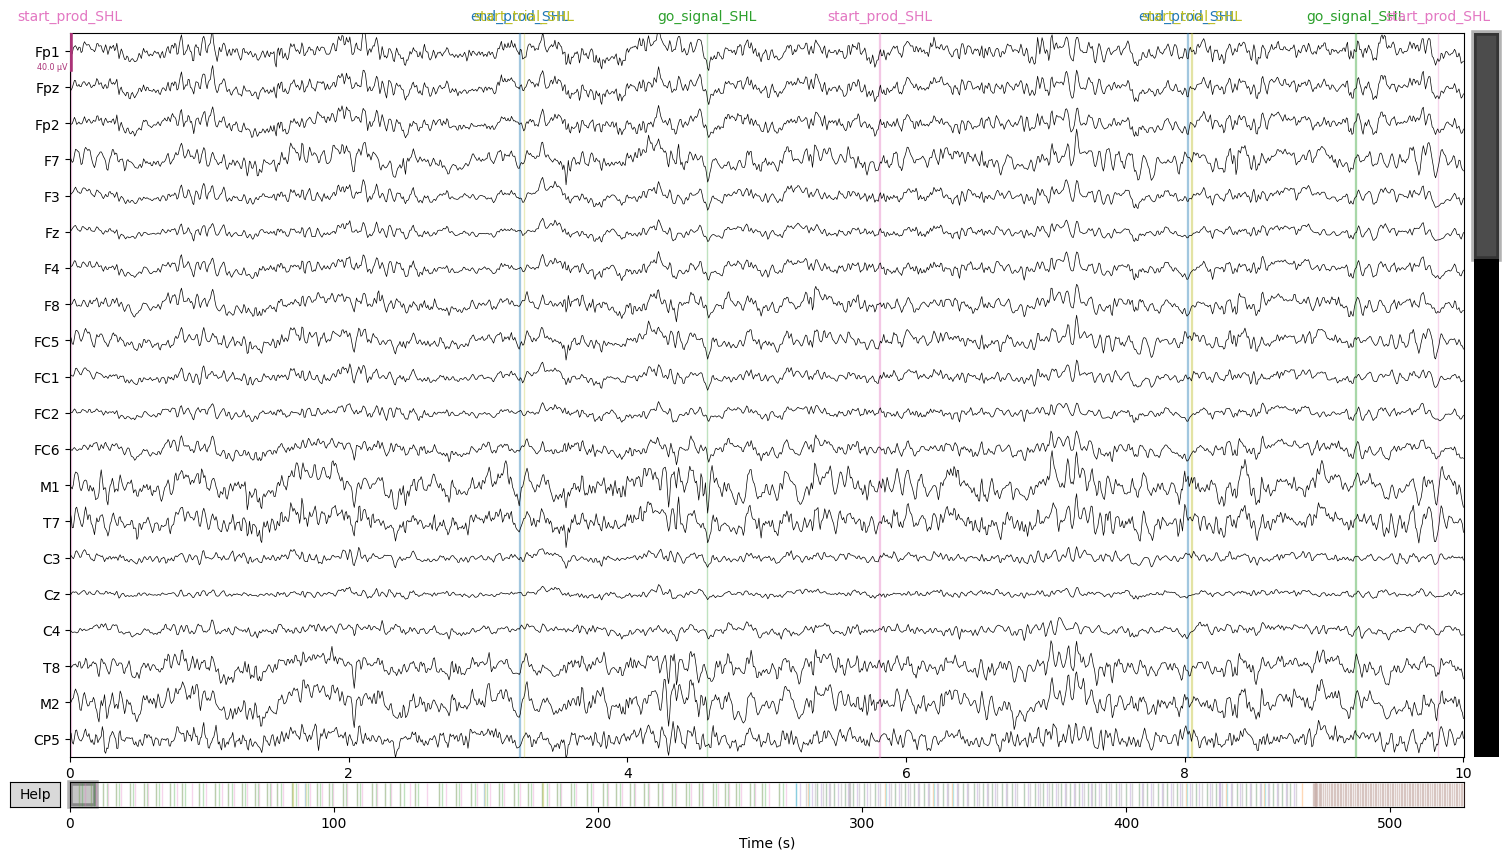

In [10]:
block.plot()

## Plot evoked responses for go_signal and start_prod events

In [3]:
# Choose channels to create epochs on
selected_channels = config.frontocentral_channels

In [4]:
#Import one subject data
subject = 'VST_02_X'
preprocessed_raw = preprocessing.get_preprocessed_raw(subject, bad_channels_exclusion=True, ICA_exclusion=True)
raw_blocks = preprocessing.get_good_raw_blocks(preprocessed_raw)

C:\Users\gautier\OneDrive - CentraleSupelec\3A - Master CNN\Supervised Project\pipeline project v0\scripts\eeg_preprocessing.py:44: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn", verbose=False)


[DONE] Importing data
[DONE] Filtering and resampling
[DONE] Excluding bad channels
Reading C:\Users\gautier\Données EEG - Supervised Project/ica_solutions/VST_02_X-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (63 components)
    Zeroing out 2 ICA components
    Projecting back using 63 PCA components
[DONE] Performing ICA
[0, 1, 502, 1003, 1508, 1511, 2018, 2523, 3031, 3541, 4045]
[DONE] Extracting good blocks


In [5]:
block_number = 3
block = raw_blocks[block_number]
block.info

Measurement date,"June 23, 2023 17:51:18 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,67 points
Good channels,"63 EEG, 1 EOG"
Bad channels,None
EOG channels,EOG
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


Start_prod epochs

In [6]:
# Choosing interesting channels with picks attribute
start_prod_epochs_dict = preprocessing.get_start_prod_epochs(block=block, block_number = block_number, subject= subject, picks=selected_channels,baseline_duration=0.1, epoch_duration=1)

In [7]:
# plotting evoked response for each condition
for condition, epochs in start_prod_epochs_dict.items():
    print("Evoked Response for the following condition : " + condition)
    epochs.copy().average().plot_joint(title="Evoked response for the start_prod epochs of the " + condition +  " condition")

Evoked Response for the following condition : SHL
No projector specified for this dataset. Please consider the method self.add_proj.
Evoked Response for the following condition : SHS
No projector specified for this dataset. Please consider the method self.add_proj.


Go_signal epochs

In [8]:
go_signal_epochs_dict, surpass_events = preprocessing.get_go_signal_epochs(block=block, block_number = block_number,  subject= subject, picks=selected_channels, baseline_duration=0.1, epoch_duration=0.8)
print("Number of events where start_prod - go_signal duration < epoch_duration: " + str(len(surpass_events)))

Number of events where start_prod - go_signal duration < epoch_duration: 75


In [9]:
# plotting evoked response for each condition
for condition, epochs in go_signal_epochs_dict.items():
    print("Evoked Response for the following condition : " + condition)
    epochs.copy().average().plot_joint(title="Evoked response for the go_signal epochs of the " + condition +  " condition")

Evoked Response for the following condition : SHL
No projector specified for this dataset. Please consider the method self.add_proj.
Evoked Response for the following condition : SHS
No projector specified for this dataset. Please consider the method self.add_proj.


# Save start_prod and go_signal epochs

## Saving go_signal and start_prod epochs 

Save on a chosen channels selection for certain epochs parameters for one subject

In [2]:
subject = 'VST_02_X'
preprocessed_raw = preprocessing.get_preprocessed_raw(subject, bad_channels_exclusion=True, ICA_exclusion=True)
raw_blocks = preprocessing.get_good_raw_blocks(preprocessed_raw)

C:\Users\gautier\OneDrive - CentraleSupelec\3A - Master CNN\Supervised Project\pipeline project v0\scripts\eeg_preprocessing.py:44: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn", verbose=False)


[DONE] Importing data
[DONE] Filtering and resampling
[DONE] Excluding bad channels
Reading C:\Users\gautier\Données EEG - Supervised Project/ica_solutions/VST_02_X-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (63 components)
    Zeroing out 2 ICA components
    Projecting back using 63 PCA components
[DONE] Performing ICA
[0, 1, 502, 1003, 1508, 1511, 2018, 2523, 3031, 3541, 4045]
[DONE] Extracting good blocks


In [3]:
# Fix badly annotated events
preprocessing.solve_annotations_mismatch(raw_blocks, subject)

In [4]:
# Define epochs parameters
start_prod_baseline_duration = 0.1
start_prod_duration = 4
go_signal_baseline_duration = 0.1
go_signal_duration = 0.8

channel_names = [channel['ch_name'] for channel in raw_blocks[0].info['chs']]
selected_channels = config.frontocentral_channels

In [5]:
for block_number, block in enumerate(raw_blocks):
    if block_number in config.bad_time_production_blocks[subject]:
        print(str(block_number))
        continue
    # Save start prod epochs
    start_prod_epochs_dict = preprocessing.get_start_prod_epochs(block=block, block_number = block_number, subject= subject, picks=selected_channels, baseline_duration=start_prod_baseline_duration, epoch_duration=start_prod_duration)
    for condition, epochs in start_prod_epochs_dict.items():
        preprocessing.save_epochs(epochs, subject, block_number, "start_prod", condition, start_prod_baseline_duration, start_prod_duration, "frontocentral")
    # Save go signal epochs
    # go_signal_epochs_dict, surpass_events = preprocessing.get_go_signal_epochs(block=block, block_number = block_number,  subject= subject, picks=selected_channels, baseline_duration=go_signal_baseline_duration, epoch_duration=go_signal_duration)
    # for condition, epochs in go_signal_epochs_dict.items():
    #     preprocessing.save_epochs(epochs, subject, block_number, "go_signal", condition, go_signal_baseline_duration, go_signal_duration, "all_channels")
    # print("[DONE] Saved epochs for block n°" + str(block_number))

Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding metadata with 1 columns
Adding m